# Olympic Rings

In [78]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.mixture
from sklearn.datasets import make_moons, make_circles
import scipy
import pandas as pd
from sklearn.preprocessing import KernelCenterer

#import code to generate data and do clustNP
from sample_distributions import pair_sample_mixture_of_GMs, sample_olympic_rings
from clustNP import clustNP, gauss_kernal_mat, gen_ZG, gen_C, clustNP_obj, proj_simplex
from clustNP_lifted import clustNP_lifted
from MoMoG import MoMoG

# Set Parameters

In [79]:
np.random.seed(0) #reproducibility

n = 1000 # number of total paired samples
nhold = 200
ntest = 200
M = 5   # true number of mixture components for our KDE
d = 2   # ambient dimension 

# Generate Rings Data

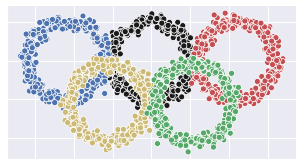

In [80]:
noise_sd = 0.1
X, component_ids, pair_ids = sample_olympic_rings(n, noise_sd=noise_sd, rand_state=0)
Xh, cid_h, pid_h = sample_olympic_rings(nhold, noise_sd=noise_sd, rand_state=111)
Xte, cid_te, pid_te = sample_olympic_rings(ntest, noise_sd=noise_sd, rand_state=99)
#plot the data and look at moons

dftr = pd.DataFrame({"x": X[:,0], "y": X[:,1], "decisions": component_ids[:,], "true_class": component_ids[:,]})
dfh = pd.DataFrame({"x": Xh[:,0], "y": Xh[:,1], "decisions": cid_h[:,], "true_class": cid_h[:,]})

#tn, fp, fn, tp = confusion_matrix(decisions_train, component_ids).ravel()
#plot data and decisions
sns.relplot(x ="x", y="y", data=dftr, hue="decisions", palette=['k', 'r', 'b', 'y', 'g'], legend=False)
ax = plt.gca()
plt.xlabel("")
plt.ylabel("")
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.set_aspect('equal', 'box')
# plt.savefig('true_rings.eps', format="eps")
# plt.savefig('true_rings.png', dpi=300)

In [81]:
X.shape

(2000, 2)

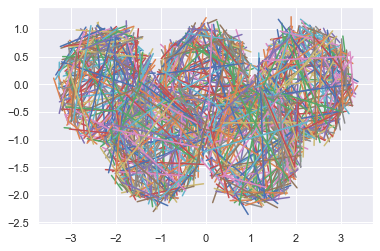

In [82]:
for i in range(n):
    pair = X[pair_ids==i]
    plt.plot(pair[:,0], pair[:,1])

# solve quartic problem

### Original Param Init

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.set(style="darkgrid")

# do a line search on sigma to find the best eigenvector initialization
Rs = [50,60,70,80,90,100]
best_ISE = 1e10;
# sigmas = np.linspace(0.2, 0.4, 21)
#sigmas = [0.23]
#sigmas = [1]
d = X.shape[1]


for R in Rs:
    sd = np.min(np.std(X, axis=0))
    sigmas = [sd*(2*n)**(-1/(d+4))]
    Z, _ = gen_ZG(X, R, 1)

    for sigma in sigmas:
#         _, Gh = gen_ZG(Xh, R, sigma, Z=Z)
#         Ch = gen_C(Xh, pid_h, Z, R, sigma)
        #Generate initialization for current sigma
#         _, G = gen_ZG(X, R, sigma, Z=Z)
#         C = gen_C(X, pair_ids, Z, R, sigma)
#         Cinv = np.linalg.inv(C)
#         A, w, _ = scipy.sparse.linalg.svds(G@Cinv@G, k=M)
        _, G = gen_ZG(X, R, sigma, Z=Z)
        C = gen_C(X, pair_ids, Z, R, sigma)
#         Cinv = np.linalg.inv(C)
#         A, w, _ = scipy.sparse.linalg.svds(G@Cinv@G, k=M)
        w, A = scipy.sparse.linalg.eigs(G, k=M)
        w = np.real(w)
        A = np.real(A)
        for i in range(M):
                A[:,i] = proj_simplex(A[:,i])
        w = w/np.sum(w)
        #w = np.ones(M,) / M
        A = A / np.sum(A,axis=0)
        #A, w, _ = scipy.sparse.linalg.svds(G, k=M)
        f, _ = clustNP_obj(A, w, G, C, n, 0)
        print(sigma, R, f)
        if f < best_ISE:
            best_ISE = f
            best_sigma = sigma
            best_R = R
            best_w = w
            best_Z = Z
            best_C = C
            best_G = G
            best_A = A
print(best_sigma, best_R, best_ISE)       

0.25130374141037365 50 0.0449692793240105
0.25130374141037365 60 0.02464003137686208
0.25130374141037365 70 0.03201608533097362
0.25130374141037365 80 0.04071193065211397
0.25130374141037365 90 0.06669685882876915
0.25130374141037365 100 0.035149484242472044
0.25130374141037365 60 0.02464003137686208


### Optimize

In [88]:
sigma = best_sigma
R = best_R
w0 = best_w

#w0 = np.array([0.5, 0.5])
Z = best_Z
C = best_C
G = best_G
A0 = best_A
#A0 = np.random.rand(R,M)
#A0 = A0 / np.sum(A0, axis=0)
ss=10

print(best_ISE)

# #solve
f_star, A_star, w_star, Z, n_iter = clustNP(X, pair_ids.astype("int"), A0, w0, Z, G, stepsize=ss, ss_decr=1, 
                                            epoch_decr = 40, method='psgd', max_iter=100, f_tol=1e-16, 
                                            grad_tol=1e-8, R=R, sigma=sigma, batch_size=64, backtrack=False,
                                            decay=0.01, momentum=0.2)

f_star

0.02464003137686208


-0.00011029927812211942

In [72]:
f_star

-8.42174115650773e-05


# Plot KDE

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

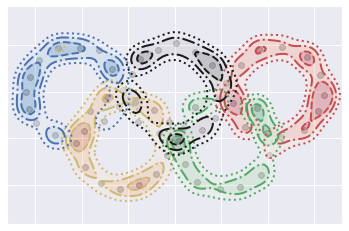

In [97]:
import sklearn.neighbors 

xmin, xmax = -3.6, 3.6
ymin, ymax = -2.5, 1.5
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
#construct kde based on discretization and learned weights
#evaluate on grid of points

#class 0
kde = sklearn.neighbors.KernelDensity(bandwidth=sigma);
kde.fit(Z, y=None, sample_weight=(w_star[0]*A_star[:,0]).clip(1e-16))
f0 = np.exp(np.reshape(kde.score_samples(positions.T).T, xx.shape))

#class 1
kde = sklearn.neighbors.KernelDensity(bandwidth=sigma);
kde.fit(Z, y=None, sample_weight=(w_star[1]*A_star[:,1]).clip(1e-16))
f1 = np.exp(np.reshape(kde.score_samples(positions.T).T, xx.shape))

#class 2
kde = sklearn.neighbors.KernelDensity(bandwidth=sigma);
kde.fit(Z, y=None, sample_weight=(w_star[2]*A_star[:,2]).clip(1e-16))
f2 = np.exp(np.reshape(kde.score_samples(positions.T).T, xx.shape))

#class 3
kde = sklearn.neighbors.KernelDensity(bandwidth=sigma);
kde.fit(Z, y=None, sample_weight=(w_star[3]*A_star[:,3]).clip(1e-16))
f3 = np.exp(np.reshape(kde.score_samples(positions.T).T, xx.shape))

#class 4
kde = sklearn.neighbors.KernelDensity(bandwidth=sigma);
kde.fit(Z, y=None, sample_weight=(w_star[4]*A_star[:,4]).clip(1e-16))
f4 = np.exp(np.reshape(kde.score_samples(positions.T).T, xx.shape))


#plot

# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)
# Contourf plot
plt.scatter(x=Z[:,0], y=Z[:,1], color="black", alpha = 0.2)
#plt.scatter(x=Z[Zlabels==1,0], y=Z[Zlabels==1,1], color='orange')
# cfset = ax.contourf(xx, yy, f0, cmap='Blues')
# cfset = ax.contourf(xx, yy, f1, cmap='Reds')

levels = [0.1, 0.15, 0.2, 0.3]


CSb = plt.contourf(xx, yy, f0, levels, cmap="Reds", alpha=sigma)
CSb2 = plt.contour(xx, yy, f0, levels,
                  colors=('r',),
                  linewidths=(2,),
                  linestyles=(':', '-.', '--', '-' ),
                  origin="lower",
                  extend='max')
CSb.cmap.set_over('r')
# plt.clabel(CSb2, fmt='%2.1f', colors='g', fontsize=10)
#plt.colorbar(CSb)
CSg = plt.contourf(xx, yy, f3, levels, cmap="Oranges", alpha=sigma)
CSg2 = plt.contour(xx, yy, f3, levels,
                  colors=('y',),
                  linewidths=(2,),
                  linestyles=(':', '-.', '--', '-' ),
                  origin="lower",
                  extend='max')
CSg.cmap.set_over('y')
#plt.clabel(CSg2, fmt='%2.2f', colors='k', fontsize=10)
#plt.colorbar(CSg)
CSk = plt.contourf(xx, yy, f4, levels, cmap="Greens", alpha=sigma)
CSk2 = plt.contour(xx, yy, f4, levels,
                  colors=('g',),
                  linewidths=(2,),
                  linestyles=(':', '-.', '--', '-' ),
                  origin="lower",
                  extend='max')
CSk.cmap.set_over('g')
#plt.clabel(CSk2, fmt='%2.1f', colors='b', fontsize=10)
#plt.colorbar(CSk)
CSo = plt.contourf(xx, yy, f2, levels, cmap="Blues", alpha=sigma)
CSo2 = plt.contour(xx, yy, f2, levels,
                  colors=('b',),
                  linewidths=(2,),
                  linestyles=(':', '-.', '--', '-' ),
                  origin="lower",
                  extend='max')
CSo.cmap.set_over('b')
#plt.clabel(CSo2, fmt='%2.1f', colors='r', fontsize=12)
#plt.colorbar(CSo)
CSr = plt.contourf(xx, yy, f1, levels, cmap="Greys", alpha=sigma)
CSr2 = plt.contour(xx, yy, f1, levels,
                  colors=('k',),
                  linewidths=(2,),
                  linestyles=(':', '-.', '--', '-' ),
                  origin="lower",
                  extend='max')
CSr.cmap.set_over('k')
# plt.clabel(CSr2, fmt='%2.1f', colors='y', fontsize=10)
#plt.colorbar(CSr)

# lines = CSo2.collections
# plt.legend(lines, levels)


plt.xlabel("")
plt.ylabel("")
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.axis('equal')
# plt.imshow(np.rot90(f0.clip(1e-1)), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# plt.imshow(np.rot90(f1.clip(1e-1)), cmap='Reds', extent=[xmin, xmax, ymin, ymax])
plt.savefig('rings_kde_orig_init.eps', format="eps")
plt.savefig('rings_kde_orig_init.png', dpi=300)

# Predict

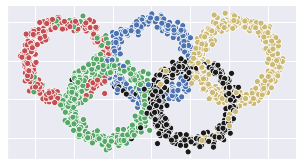

In [74]:
#make predictions
phats_train = np.zeros((X.shape[0], M))
phats_te = np.zeros((Xte.shape[0], M))
for i in range(X.shape[0]):
    kx = gauss_kernal_mat(X[i, np.newaxis], Z, sigma)
    phats_train[i, :] = kx@A_star
for i in range(Xh.shape[0]):
    kxte = gauss_kernal_mat(Xte[i,np.newaxis], Z, sigma)
    phats_te[i, :] = kxte@A_star
ltr = np.zeros((X.shape[0], M))
lte = np.zeros((Xte.shape[0], M))
for i in set(pair_ids):
    ltr[pair_ids==i, :] = np.tile(w_star.T*np.prod(phats_train[pair_ids==i,np.newaxis], axis=0), (2,1))
lte = w_star.T*phats_te
decisions_train = np.argmax(ltr, 1)
decisions_te = np.argmax(lte, 1)


dftr = pd.DataFrame({"x": X[:,0], "y": X[:,1], "decisions": decisions_train[:,], "true_class": component_ids[:,]},)
dfte = pd.DataFrame({"x": Xte[:,0], "y": Xte[:,1], "decisions": decisions_te[:,], "true_class": cid_te[:,]})

#tn, fp, fn, tp = confusion_matrix(decisions_train, component_ids).ravel()
#plot data and decisions
sns.relplot(x ="x", y="y", data=dftr, hue="decisions", palette=['y', 'r', 'g', 'b', 'k'], legend=False)
ax = plt.gca()
plt.xlabel("")
plt.ylabel("")
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.set_aspect('equal', 'box')
# plt.savefig('rings_kde_orig_init.png', dpi=600)

In [75]:
#compute best accuracy of clustering

cm = sklearn.metrics.confusion_matrix(component_ids, decisions_train, normalize='all')
import itertools
perms = np.array(tuple((itertools.permutations(range(cm.shape[0])))))
acc = 0
for perm in range(perms.shape[0]):
    tr = np.trace(cm[perms[perm,:],:])
    if tr > acc:
        acc = tr
acc

0.8669999999999999

In [76]:
sklearn.metrics.adjusted_rand_score(component_ids, decisions_train)

0.7149215609114061

### Eigenvector Init

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.set(style="darkgrid")

#set random seed
np.random.seed(0)

# do a line search on sigma to find the best eigenvector initialization
R = 2*n
best_ISE = 1e10;
A = np.random.rand(R,M)
A = A / np.sum(A,axis=(0,1))
K = np.zeros((R,R))
n_power_iter = 2000
power_iter_tol = 1e-8

sigmas = np.linspace(0.01, 0.3, 30)
# #Scott's rule 
d = X.shape[1]
sd = np.mean(np.std(X, axis=0))
sigmas = [sd*(2*n)**(-1/(d+4))] 
Z = X
for sigma in sigmas:
    #Generate initialization for current sigma
    
    # reorder the kernel matrix, Assumes X = [x11; x12; x21; x22; ...; xn1; xn2] where (xi1, xi2) is a pair
    _, G = gen_ZG(X, R, sigma, Z)
    C = gen_C(X, pair_ids, Z, R, sigma)
    _, Gh = gen_ZG(Xh, R, sigma, Z=Z)
    Ch = gen_C(Xh, pid_h, Z, R, sigma)
    K[1::2] = G[0::2]
    K[0::2] = G[1::2]
    #center the reordered kernel matrix (centering and row reordering commute)
    centerer = KernelCenterer().fit(K)
    K = centerer.transform(K)

    #find the first right eigenvector
    w, vecs = scipy.sparse.linalg.eigs(K, k=M, which='LR')
    vecs = np.real(vecs)
    a1 = vecs[:,0]
    a2 = vecs[:,1]
    A[:,0] = a1.flatten()
    
    #find the second 
    Ka1 = K@A[:,0]
    normsq_Ka1 = np.inner(A[:,0], Ka1)
    A[:,1] = A[:,1]/np.linalg.norm(A[:,1].T@K@A[:,1]) #normalize
    a2 = A[:,1]
    count = 0
    while count <= n_power_iter:
        a2_old = a2
        a2 = K@a2
        #print(np.linalg.norm(a2), np.linalg.norm(a2.T@K@a2))
        #a2 = a2/np.linalg.norm(a2.T@K@a2)
        a2 = a2 - a1*(np.inner(a2, Ka1)/normsq_Ka1)
        a2 = a2/(np.abs(a2.T@K@a2)**0.5)
        #a2 = a2/np.linalg.norm(a2)
        count+=1
        #break when estimate stops improving
        if np.linalg.norm(a2-a2_old) < power_iter_tol:
            break
    print('number of power iterations = ', count)
    
    #flip signs of eigenvecs if most elements are negative, threshold negative elements to zero
    if np.sum(a1>0) > R//2:
        a1 = a1.clip(0)
    else:
        a1 = (-a1).clip(0)
    a1 = a1/np.sum(a1)
    A[:,0] = a1.flatten()
    
    if np.sum(a2>0) > R//2:
        a2 = a2.clip(0)
    else:
        a2 = (-a2).clip(0)
    a2 = a2/np.sum(a2)
    A[:,1] = a2
    
    w = np.real(w)
    w = w/np.sum(w)
    A = A / np.sum(A,axis=0)
    
    #store initialization with lowest objective
    f, _ = clustNP_obj(A, w, Gh, Ch, n, 0)
    print(sigma, f)
    if f < best_ISE:
        best_ISE = f
        best_sigma = sigma
        best_R = R
        best_w = w
        best_Z = Z
        best_C = C
        best_G = G
        best_A = A
print(best_sigma, best_ISE) 

### Optimize

In [ ]:
sigma = best_sigma
R = best_R
w0 = best_w
#w0 = np.array([0.5, 0.5])
Z = best_Z
C = best_C
G = best_G
A0 = best_A
#A0 = np.random.rand(R,M)
#A0 = A0 / np.sum(A0, axis=0)
ss=10

A_star = A0
w_star = w0

print(best_ISE)

# #solve
f_star, A_star, w_star, Z, n_iter = clustNP(X, pair_ids, A0, w0, Z, G, stepsize=ss, ss_decr=0.9, 
                                            epoch_decr = 40, method='psgd', max_iter=20, f_tol=1e-10, 
                                            grad_tol=1e-8, R=R, sigma=sigma, batch_size=128, backtrack=False,
                                            decay=0.05, momentum=0.1)




# Plot KDE

In [ ]:
import sklearn.neighbors 

xmin, xmax = -4, 4
ymin, ymax = -3, 2
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
#construct kde based on discretization and learned weights
#evaluate on grid of points

#class 0
kde = sklearn.neighbors.KernelDensity(bandwidth=sigma);
kde.fit(Z, y=None, sample_weight=(w_star[0]*A_star[:,0]).clip(1e-16))
f0 = np.exp(np.reshape(kde.score_samples(positions.T).T, xx.shape))

#class 1
kde = sklearn.neighbors.KernelDensity(bandwidth=sigma);
kde.fit(Z, y=None, sample_weight=(w_star[1]*A_star[:,1]).clip(1e-16))
f1 = np.exp(np.reshape(kde.score_samples(positions.T).T, xx.shape))

#class 2
kde = sklearn.neighbors.KernelDensity(bandwidth=sigma);
kde.fit(Z, y=None, sample_weight=(w_star[2]*A_star[:,2]).clip(1e-16))
f2 = np.exp(np.reshape(kde.score_samples(positions.T).T, xx.shape))

#class 3
kde = sklearn.neighbors.KernelDensity(bandwidth=sigma);
kde.fit(Z, y=None, sample_weight=(w_star[3]*A_star[:,3]).clip(1e-16))
f3 = np.exp(np.reshape(kde.score_samples(positions.T).T, xx.shape))

#class 4
kde = sklearn.neighbors.KernelDensity(bandwidth=sigma);
kde.fit(Z, y=None, sample_weight=(w_star[4]*A_star[:,4]).clip(1e-16))
f4 = np.exp(np.reshape(kde.score_samples(positions.T).T, xx.shape))


#plot

# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)
# Contourf plot
#plt.scatter(x=Z[:,0], y=Z[:,1], color="black", alpha = 0.2)
#plt.scatter(x=Z[Zlabels==1,0], y=Z[Zlabels==1,1], color='orange')
# cfset = ax.contourf(xx, yy, f0, cmap='Blues')
# cfset = ax.contourf(xx, yy, f1, cmap='Reds')

num_steps = 5
m0 = np.amax(f0)
m1 = np.amax(f1)
m2 = np.amax(f2)
m3 = np.amax(f3)
m4 = np.amax(f4)
step0 = m0/num_steps
step1 = m1/num_steps
step2 = m2/num_steps
step3 = m3/num_steps
step4 = m4/num_steps
levels0 = np.arange(0.0, m0, step0) + step0
levels1 = np.arange(0.0, m1, step1) + step1
levels2 = np.arange(0.0, m2, step2) + step2
levels3 = np.arange(0.0, m3, step3) + step3
levels4 = np.arange(0.0, m4, step4) + step4

CSr = plt.contourf(xx, yy, f0, levels0, cmap="Oranges", alpha=sigma)
CSr2 = plt.contour(xx, yy, f0, levels0,
                  colors=('y',),
                  linewidths=(2,),
                  linestyles=(':', '--', '-' ),
                  origin="lower")
plt.clabel(CSr2, fmt='%2.1f', colors='y', fontsize=10)
#plt.colorbar(CSr)
CSb = plt.contourf(xx, yy, f1, levels1, cmap="Greens", alpha=sigma)
CSb2 = plt.contour(xx, yy, f1, levels1,
                  colors=('g',),
                  linewidths=(2,),
                  linestyles=(':','--', '-' ),
                  origin="lower")
plt.clabel(CSb2, fmt='%2.1f', colors='g', fontsize=10)
#plt.colorbar(CSb)
CSg = plt.contourf(xx, yy, f2, levels2, cmap="Reds", alpha=sigma)
CSg2 = plt.contour(xx, yy, f2, levels2,
                  colors=('r',),
                  linewidths=(2,),
                  linestyles=(':', '--', '-' ),
                  origin="lower")
plt.clabel(CSg2, fmt='%2.1f', colors='r', fontsize=10)
#plt.colorbar(CSg)
CSk = plt.contourf(xx, yy, f3, levels3, cmap="Blues", alpha=sigma)
CSk2 = plt.contour(xx, yy, f3, levels3,
                  colors=('b',),
                  linewidths=(2,),
                  linestyles=(':','--', '-' ),
                  origin="lower")
plt.clabel(CSk2, fmt='%2.1f', colors='b', fontsize=10)
#plt.colorbar(CSk)
CSo = plt.contourf(xx, yy, f4, levels4, cmap="bone", alpha=sigma)
CSo2 = plt.contour(xx, yy, f4, levels4,
                  colors=('k',),
                  linewidths=(2,),
                  linestyles=(':', '--', '-' ),
                  origin="lower")
plt.clabel(CSo2, fmt='%2.1f', colors='k', fontsize=10)
#plt.colorbar(CSo)



plt.xlabel("")
plt.ylabel("")
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
# plt.imshow(np.rot90(f0.clip(1e-1)), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# plt.imshow(np.rot90(f1.clip(1e-1)), cmap='Reds', extent=[xmin, xmax, ymin, ymax])
plt.savefig('circles_kde_orig_init.eps', format="eps")
plt.savefig('circles_kde_orig_init.png', dpi=300)

### Hybrid Parameter Search

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.set(style="darkgrid")

# do a line search on sigma to find the best eigenvector initialization
Rs = [30, 40, 50]
best_ISE = 1e10;
sigmas = np.linspace(0.15, 1, 86)
#sigmas = [0.23]
#sigmas = [0.35]
Z, _ = gen_ZG(X, R, 1)

# d = Z.shape[1]
# sd = np.mean(np.std(Z, axis=0))
# sigmas = [sd*(R)**(-1/(d+4))]

for R in Rs:
    Z, _ = gen_ZG(X, R, 1)
    for sigma in sigmas:
        #Generate initialization for current sigma
        _, G = gen_ZG(X, R, sigma, Z)
        C = gen_C(X, pair_ids, Z, R, sigma)
        _, Gh = gen_ZG(Xh, R, sigma, Z)
        Ch = gen_C(Xh, pair_ids, Z, R, sigma)
        #Cinv = np.linalg.inv(C)
        K = gauss_kernal_mat(Z, X, sigma=1)
        A, w, _ = scipy.sparse.linalg.svds(K, k=M)
        for i in range(M):
            A[:,i] = proj_simplex(A[:,i])
        #w = w * np.sum(A,axis=0)
        w = w/np.sum(w)
        A = A / np.sum(A,axis=0)
        #A, w, _ = scipy.sparse.linalg.svds(G, k=M)
#         #evaluate ISE on hold out data
#         _, Gh = gen_ZG(Xh, R, sigma, Z)
#         Ch = gen_C(Xh, pid_h, Z, R, sigma)
        f, _ = clustNP_obj(A, w, Gh, Ch, n, 0)
        print(sigma, R, f)
        if f < best_ISE:
            best_ISE = f
            best_sigma = sigma
            best_R = R
            best_w = w
            best_Z = Z
            best_C = C
            best_G = G
            best_A = A
print(best_sigma, best_R, best_ISE)       

### Optimize

In [ ]:
sigma = best_sigma
R = best_R
w0 = best_w
#w0 = np.array([0.5, 0.5])
Z = best_Z
C = best_C
G = best_G
A0 = best_A
#A0 = np.random.rand(R,M)
#A0 = A0 / np.sum(A0, axis=0)
ss=10

A_star = A0
w_star = w0

print(best_ISE)

# #solve
f_star, A_star, w_star, Z, n_iter = clustNP(X, pair_ids, A0, w0, Z, G, stepsize=ss, ss_decr=0.9, 
                                            epoch_decr = 40, method='psgd', max_iter=400, f_tol=1e-12, 
                                            grad_tol=1e-8, R=R, sigma=sigma, batch_size=32, backtrack=False,
                                            decay=0.0001, momentum=0.1)




# Plot KDE

In [ ]:
import sklearn.neighbors 

xmin, xmax = -4, 4
ymin, ymax = -3, 2
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
#construct kde based on discretization and learned weights
#evaluate on grid of points

#class 0
kde = sklearn.neighbors.KernelDensity(bandwidth=sigma);
kde.fit(Z, y=None, sample_weight=(w_star[0]*A_star[:,0]).clip(1e-16))
f0 = np.exp(np.reshape(kde.score_samples(positions.T).T, xx.shape))

#class 1
kde = sklearn.neighbors.KernelDensity(bandwidth=sigma);
kde.fit(Z, y=None, sample_weight=(w_star[1]*A_star[:,1]).clip(1e-16))
f1 = np.exp(np.reshape(kde.score_samples(positions.T).T, xx.shape))

#class 2
kde = sklearn.neighbors.KernelDensity(bandwidth=sigma);
kde.fit(Z, y=None, sample_weight=(w_star[2]*A_star[:,2]).clip(1e-16))
f2 = np.exp(np.reshape(kde.score_samples(positions.T).T, xx.shape))

#class 3
kde = sklearn.neighbors.KernelDensity(bandwidth=sigma);
kde.fit(Z, y=None, sample_weight=(w_star[3]*A_star[:,3]).clip(1e-16))
f3 = np.exp(np.reshape(kde.score_samples(positions.T).T, xx.shape))

#class 4
kde = sklearn.neighbors.KernelDensity(bandwidth=sigma);
kde.fit(Z, y=None, sample_weight=(w_star[4]*A_star[:,4]).clip(1e-16))
f4 = np.exp(np.reshape(kde.score_samples(positions.T).T, xx.shape))


#plot

# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)
# Contourf plot
plt.scatter(x=Z[:,0], y=Z[:,1], color="black", alpha = 0.2)
#plt.scatter(x=Z[Zlabels==1,0], y=Z[Zlabels==1,1], color='orange')
# cfset = ax.contourf(xx, yy, f0, cmap='Blues')
# cfset = ax.contourf(xx, yy, f1, cmap='Reds')

num_steps = 5
m0 = np.amax(f0)
m1 = np.amax(f1)
m2 = np.amax(f2)
m3 = np.amax(f3)
m4 = np.amax(f4)
step0 = m0/num_steps
step1 = m1/num_steps
step2 = m2/num_steps
step3 = m3/num_steps
step4 = m4/num_steps
levels0 = np.arange(0.0, m0, step0) + step0
levels1 = np.arange(0.0, m1, step1) + step1
levels2 = np.arange(0.0, m2, step2) + step2
levels3 = np.arange(0.0, m3, step3) + step3
levels4 = np.arange(0.0, m4, step4) + step4

CSr = plt.contourf(xx, yy, f0, levels0, cmap="Oranges", alpha=sigma)
CSr2 = plt.contour(xx, yy, f0, levels0,
                  colors=('y',),
                  linewidths=(2,),
                  linestyles=(':', '--', '-' ),
                  origin="lower")
plt.clabel(CSr2, fmt='%2.1f', colors='y', fontsize=10)
#plt.colorbar(CSr)
CSb = plt.contourf(xx, yy, f1, levels1, cmap="Greens", alpha=sigma)
CSb2 = plt.contour(xx, yy, f1, levels1,
                  colors=('g',),
                  linewidths=(2,),
                  linestyles=(':','--', '-' ),
                  origin="lower")
plt.clabel(CSb2, fmt='%2.1f', colors='g', fontsize=10)
#plt.colorbar(CSb)
CSg = plt.contourf(xx, yy, f2, levels2, cmap="Reds", alpha=sigma)
CSg2 = plt.contour(xx, yy, f2, levels2,
                  colors=('r',),
                  linewidths=(2,),
                  linestyles=(':', '--', '-' ),
                  origin="lower")
plt.clabel(CSg2, fmt='%2.1f', colors='r', fontsize=10)
#plt.colorbar(CSg)
CSk = plt.contourf(xx, yy, f3, levels3, cmap="Blues", alpha=sigma)
CSk2 = plt.contour(xx, yy, f3, levels3,
                  colors=('b',),
                  linewidths=(2,),
                  linestyles=(':','--', '-' ),
                  origin="lower")
plt.clabel(CSk2, fmt='%2.1f', colors='b', fontsize=10)
#plt.colorbar(CSk)
CSo = plt.contourf(xx, yy, f4, levels4, cmap="bone", alpha=sigma)
CSo2 = plt.contour(xx, yy, f4, levels4,
                  colors=('k',),
                  linewidths=(2,),
                  linestyles=(':', '--', '-' ),
                  origin="lower")
plt.clabel(CSo2, fmt='%2.1f', colors='k', fontsize=10)
#plt.colorbar(CSo)



plt.xlabel("")
plt.ylabel("")
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
# plt.imshow(np.rot90(f0.clip(1e-1)), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# plt.imshow(np.rot90(f1.clip(1e-1)), cmap='Reds', extent=[xmin, xmax, ymin, ymax])
plt.savefig('circles_kde_hybrid_init.eps', format="eps")
plt.savefig('circles_kde_hybrid_init.png', dpi=300)

# Spectral Clustering

In [ ]:
import sklearn.cluster
spclust = sklearn.cluster.SpectralClustering(n_clusters=M)
spclust.fit(X)
#d = clust.get_params()

In [ ]:
#np.sum(spclust.labels_)
#spclust.affinity_matrix_
dftr = pd.DataFrame({"x": X[:,0], "y": X[:,1], "decisions": spclust.labels_, "true_class": component_ids})
#plot data and decisions
sns.relplot(x ="x", y="y", data=dftr, hue="decisions", palette=['g', 'k', 'b', 'r', 'y'], legend=False)
ax = plt.gca()
plt.xlabel("")
plt.ylabel("")
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.set_aspect('equal', 'box')

# Constrained Spectral Clustering

In [ ]:
from clustering_methods import constr_spec_clust

connectivity = np.zeros((2*n, 2*n))
for i in range(n):
    i, j = tuple(np.nonzero(pair_ids==i)[0])
    connectivity[i,j] = 1
    connectivity[j,i] = 1
Q = connectivity
A = spclust.affinity_matrix_
beta = 1
u_star, labels = constr_spec_clust(A, Q, beta=beta, n_clust=M)

In [ ]:
df = pd.DataFrame({"x": X[:,0], "y": X[:,1], "decisions": labels, "true_class": component_ids})
#plot data and decisions
sns.relplot(x ="x", y="y", data=df, hue="decisions", palette=['y', 'k', 'b', 'g', 'r'], legend=False)
ax = plt.gca()
plt.xlabel("")
plt.ylabel("")
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.set_aspect('equal', 'box')
plt.savefig('rings_constr_spectral.eps', format="eps")
plt.savefig('rings_constr_spectral.png', dpi=300)

In [ ]:
#compute best accuracy of clustering

cm = sklearn.metrics.confusion_matrix(component_ids, labels, normalize='all')
import itertools
perms = np.array(tuple((itertools.permutations(range(cm.shape[0])))))
acc = 0
for perm in range(perms.shape[0]):
    tr = np.trace(cm[perms[perm,:],:])
    if tr > acc:
        acc = tr
acc

In [ ]:
sklearn.metrics.adjusted_rand_score(component_ids, labels)

# PCK-means

In [ ]:
from sklearn import datasets, metrics
from active_semi_clustering.semi_supervised.pairwise_constraints import PCKMeans
pck = PCKMeans(n_clusters=M)
# generate list of tuples for pairwise constraints
ml = [tuple(np.nonzero(pair_ids==i)[0]) for i in range(n)]
pck.fit(X, ml=ml)

In [ ]:
df = pd.DataFrame({"x": X[:,0], "y": X[:,1], "decisions": pck.labels_, "true_class": component_ids})
#plot data and decisions
sns.relplot(x ="x", y="y", data=df, hue="decisions", palette=['r', 'y', 'k', 'g', 'b'], legend=False)
ax = plt.gca()
plt.xlabel("")
plt.ylabel("")
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.set_aspect('equal', 'box')
plt.savefig('rings_pckmeans.eps', format="eps")
plt.savefig('rings_pckmeans.png', dpi=300)

In [ ]:
#compute best accuracy of clustering

cm = sklearn.metrics.confusion_matrix(component_ids, pck.labels_, normalize='all')
import itertools
perms = np.array(tuple((itertools.permutations(range(cm.shape[0])))))
acc = 0
for perm in range(perms.shape[0]):
    tr = np.trace(cm[perms[perm,:],:])
    if tr > acc:
        acc = tr
acc

In [ ]:
sklearn.metrics.adjusted_rand_score(component_ids, pck.labels_)

# NPMIX

In [ ]:
from NPMIX import NPMIX
labels, ofit_gmm, gmm_assn = NPMIX(X, M=M, M_over=2*M)

In [ ]:
df = pd.DataFrame({"x": X[:,0], "y": X[:,1], "decisions": labels, "true_class": component_ids})
#plot data and decisions
sns.relplot(x ="x", y="y", data=df, hue="decisions", palette=['y', 'r', 'k', 'g', 'b'], legend=False)
plt.xlabel("")
plt.ylabel("")
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.set_aspect('equal', 'box')
plt.savefig('rings_npmix.eps', format="eps")
plt.savefig('rings_npmix.png', dpi=300)#compute best accuracy of clustering

cm = sklearn.metrics.confusion_matrix(component_ids, labels, normalize='all')
import itertools
perms = np.array(tuple((itertools.permutations(range(cm.shape[0])))))
acc = 0
for perm in range(perms.shape[0]):
    tr = np.trace(cm[perms[perm,:],:])
    if tr > acc:
        acc = tr
ARI = sklearn.metrics.adjusted_rand_score(component_ids, labels)        
print(acc, ARI)



# Constrained GMM for paired samples

In [16]:
from constr_gmm import constr_gmm
M=5
constr_gmm = constr_gmm(X,pair_ids,M,50)     
constr_gmm.run()
labels= np.argmax(constr_gmm.predict(X), axis=1)

In [17]:
set(labels)

{0, 1, 2, 3, 4}

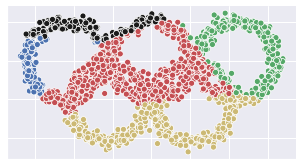

In [39]:
df = pd.DataFrame({"x": X[:,0], "y": X[:,1], "decisions": labels, "true_class": component_ids})
#plot data and decisions
sns.relplot(x ="x", y="y", data=df, hue="decisions", palette=['y', 'r', 'k', 'g', 'b'], legend=False)
plt.xlabel("")
plt.ylabel("")
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.set_aspect('equal')
plt.savefig('rings_constr_gmm.eps', format="eps")
plt.savefig('rings_constr_gmm.png', dpi=300)

In [19]:
#compute best accuracy of clustering

cm = sklearn.metrics.confusion_matrix(component_ids, labels, normalize='all')
import itertools
perms = np.array(tuple((itertools.permutations(range(cm.shape[0])))))
acc = 0
for perm in range(perms.shape[0]):
    tr = np.trace(cm[perms[perm,:],:])
    if tr > acc:
        acc = tr
acc

0.461

In [20]:
sklearn.metrics.adjusted_rand_score(component_ids, labels)

0.18656057160048142

# MV-LVM

In [40]:
X1, cid1, pid1 = sample_olympic_rings(n//3, noise_sd=noise_sd, rand_state=0)
X2, cid2, pid2 = sample_olympic_rings(n//3, noise_sd=noise_sd, rand_state=111)
X3, cid3, pid3 = sample_olympic_rings(n//3, noise_sd=noise_sd, rand_state=222)

In [41]:
from clustering_methods import MVLVM
sd = np.min(np.std(X, axis=0))
sigma = sd*(2*n)**(-1/(d+4))
A, w = MVLVM(X1,X2,X3,k=5,sigma=0.5*sigma, n_iter=100)
Xa = np.vstack((X1,X2))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

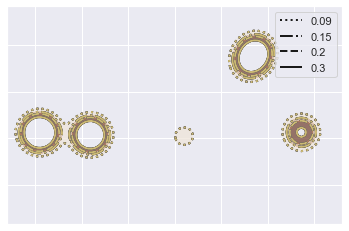

In [42]:
import sklearn.neighbors 

xmin, xmax = -3.6, 3.6
ymin, ymax = -2.5, 1.5
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
#construct kde based on discretization and learned weights
#evaluate on grid of points

#class 0
kde0 = sklearn.neighbors.KernelDensity(bandwidth=sigma);
kde0.fit(Xa, y=None, sample_weight=(A[:,0]).clip(1e-16))
f0 = np.exp(np.reshape(kde0.score_samples(positions.T).T, xx.shape))

#class 1
kde1 = sklearn.neighbors.KernelDensity(bandwidth=sigma);
kde1.fit(Xa, y=None, sample_weight=(A[:,1]).clip(1e-16))
f1 = np.exp(np.reshape(kde1.score_samples(positions.T).T, xx.shape))

#class 2
kde2 = sklearn.neighbors.KernelDensity(bandwidth=sigma);
kde2.fit(Xa, y=None, sample_weight=(A[:,2]).clip(1e-16))
f2 = np.exp(np.reshape(kde2.score_samples(positions.T).T, xx.shape))

#class 3
kde3 = sklearn.neighbors.KernelDensity(bandwidth=sigma);
kde3.fit(Xa, y=None, sample_weight=(A[:,3]).clip(1e-16))
f3 = np.exp(np.reshape(kde3.score_samples(positions.T).T, xx.shape))

#class 4
kde4 = sklearn.neighbors.KernelDensity(bandwidth=sigma);
kde4.fit(Xa, y=None, sample_weight=(A[:,4]).clip(1e-16))
f4 = np.exp(np.reshape(kde4.score_samples(positions.T).T, xx.shape))


#plot

# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)
# Contourf plot
# plt.scatter(x=Z[:,0], y=Z[:,1], color="black", alpha = 0.2)
#plt.scatter(x=Z[Zlabels==1,0], y=Z[Zlabels==1,1], color='orange')
# cfset = ax.contourf(xx, yy, f0, cmap='Blues')
# cfset = ax.contourf(xx, yy, f1, cmap='Reds')

levels = [0.09, 0.15, 0.2, 0.3]


CSb = plt.contourf(xx, yy, f0, levels, cmap="Greens", alpha=sigma)
CSb2 = plt.contour(xx, yy, f0, levels,
                  colors=('g',),
                  linewidths=(2,),
                  linestyles=(':', '-.', '--', '-' ),
                  origin="lower",
                  extend='max')
CSb.cmap.set_over('g')
# plt.clabel(CSb2, fmt='%2.1f', colors='g', fontsize=10)
#plt.colorbar(CSb)
CSg = plt.contourf(xx, yy, f3, levels, cmap="Reds", alpha=sigma)
CSg2 = plt.contour(xx, yy, f3, levels,
                  colors=('r',),
                  linewidths=(2,),
                  linestyles=(':', '-.', '--', '-' ),
                  origin="lower",
                  extend='max')
CSg.cmap.set_over('r')
#plt.clabel(CSg2, fmt='%2.2f', colors='k', fontsize=10)
#plt.colorbar(CSg)
CSk = plt.contourf(xx, yy, f4, levels, cmap="Blues", alpha=sigma)
CSk2 = plt.contour(xx, yy, f4, levels,
                  colors=('b',),
                  linewidths=(2,),
                  linestyles=(':', '-.', '--', '-' ),
                  origin="lower",
                  extend='max')
CSk.cmap.set_over('b')
#plt.clabel(CSk2, fmt='%2.1f', colors='b', fontsize=10)
#plt.colorbar(CSk)
CSo = plt.contourf(xx, yy, f2, levels, cmap="Greys", alpha=sigma)
CSo2 = plt.contour(xx, yy, f2, levels,
                  colors=('k',),
                  linewidths=(2,),
                  linestyles=(':', '-.', '--', '-' ),
                  origin="lower",
                  extend='max')
CSo.cmap.set_over('k')
#plt.clabel(CSo2, fmt='%2.1f', colors='r', fontsize=12)
#plt.colorbar(CSo)
CSr = plt.contourf(xx, yy, f1, levels, cmap="Oranges", alpha=sigma)
CSr2 = plt.contour(xx, yy, f1, levels,
                  colors=('y',),
                  linewidths=(2,),
                  linestyles=(':', '-.', '--', '-' ),
                  origin="lower",
                  extend='max')
CSr.cmap.set_over('r')
# plt.clabel(CSr2, fmt='%2.1f', colors='y', fontsize=10)
#plt.colorbar(CSr)

lines = CSo2.collections
plt.legend(lines, levels)


plt.xlabel("")
plt.ylabel("")
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.axis('equal')
# plt.imshow(np.rot90(f0.clip(1e-1)), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# plt.imshow(np.rot90(f1.clip(1e-1)), cmap='Reds', extent=[xmin, xmax, ymin, ymax])
plt.savefig('rings_kde_mvlvm.eps', format="eps")
plt.savefig('rings_kde_mvlvm.png', dpi=300)

In [43]:
set(decisions_train)

{0, 1, 2, 3, 4}

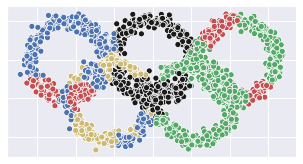

In [44]:
#make predictions
vals_tr = np.zeros((Xa.shape[0] + X3.shape[0],M))
vals_tr[:,0] = kde0.score_samples(np.vstack((Xa,X3)))
vals_tr[:,1] = kde1.score_samples(np.vstack((Xa,X3)))
vals_tr[:,2] = kde2.score_samples(np.vstack((Xa,X3)))
vals_tr[:,3] = kde3.score_samples(np.vstack((Xa,X3)))
vals_tr[:,4] = kde4.score_samples(np.vstack((Xa,X3)))
decisions_train = np.argmax(vals_tr, 1)
vals_te = np.zeros((Xte.shape[0],M))
# vals_te[:,0] = kde0.score_samples(Xte)
# vals_te[:,1] = kde1.score_samples(Xte)
# decisions_te = np.argmax(vals_te, 1)


dftr = pd.DataFrame({"x": np.hstack((Xa[:,0],X3[:,0])), "y": np.hstack((Xa[:,1],X3[:,1])), "decisions": decisions_train[:,], "true_class": np.hstack((cid1,cid2,cid3)).T},)
# dfte = pd.DataFrame({"x": Xte[:,0], "y": Xte[:,1], "decisions": decisions_te[:,], "true_class": cid_te[:,]})

#tn, fp, fn, tp = confusion_matrix(decisions_train, component_ids).ravel()
#plot data and decisions
sns.relplot(x ="x", y="y", data=dftr, hue="decisions", palette=["y", "g", 'k', 'b', 'r'], legend=False)
plt.xlabel("")
plt.ylabel("")
ax = plt.gca()
ax.set_aspect('equal')
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
plt.savefig('rings_mvlvm.png', dpi=300)

# GMM

In [ ]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=M)
labels = gmm.fit_predict(X)

In [ ]:
df = pd.DataFrame({"x": X[:,0], "y": X[:,1], "decisions": labels, "true_class": component_ids})
#plot data and decisions
sns.relplot(x ="x", y="y", data=df, hue="decisions", palette=['y', 'r', 'k', 'g', 'b'], legend=False)
ax = plt.gca()
plt.xlabel("")
plt.ylabel("")
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.set_aspect('equal', 'box')
plt.savefig('rings_gmm.eps', format="eps")
plt.savefig('rings_gmm.png', dpi=300)

In [ ]:
#compute best accuracy of clustering

cm = sklearn.metrics.confusion_matrix(component_ids, labels, normalize='all')
import itertools
perms = np.array(tuple((itertools.permutations(range(cm.shape[0])))))
acc = 0
for perm in range(perms.shape[0]):
    tr = np.trace(cm[perms[perm,:],:])
    if tr > acc:
        acc = tr
acc

In [ ]:
sklearn.metrics.adjusted_rand_score(component_ids, labels)

# DBSCAN Init

In [ ]:
db = sklearn.cluster.DBSCAN(eps=0.05, min_samples=5, 
                       metric='euclidean', metric_params=None, algorithm='auto', 
                       leaf_size=30, p=None, n_jobs=None)
db.fit(X)
Z = db.components_
Z

In [ ]:
plt.scatter(X[db.labels_==0,0], X[db.labels_==0,1])
plt.scatter(X[db.labels_==1,0], X[db.labels_==1,1])